In [1]:
from utils import *

In [533]:
def compute_h(G,a,b,N):
    h = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,i):
            if (i,j) in nx.edges(G):
                h[i][j]= 0.5*np.log(a/b)
                h[j][i]= 0.5*np.log(a/b) 
            else:
                h[i][j] = 0.5*np.log((N-a)/(N-b))
                h[j][i] = 0.5*np.log((N-a)/(N-b))
    return h
    
def olddeltaEnergy(node,x,h):
    dE = 0
    for i in range(len(x)):
        if i!=node:
            dE += 2*x[node]*h[node,i]*x[i]
    return dE

def deltaEnergy(node,x,h):
    dE = 0
    x = np.array(x)
    hnode = np.array(h[node])
    dE += 2*x[node]*np.matmul(x,hnode)
    return dE

def ind_max_list(l):
    lmax = 0
    indmax = None
    for ind,val in enumerate(l):
        if val>=lmax:
            lmax = val
            indmax = ind
    return indmax, lmax
            

In [626]:

#standard loop where I compute the probabilities for each possible transition
def loop1(x,pt,N,h,calculation,count):
    deltaE = []
    
    if calculation:
        for v in range(N):
            deltaE+=[deltaEnergy(v,x,h)]
        A = [min([1,np.exp(-dE)]) for dE in deltaE]
        pt = [a/N for a in A]
        pt += [1-sum(pt)]
    new_v = np.random.choice(range(N+1), p=pt)
    if (new_v != N):
        x[new_v] = -x[new_v]
        calculation = True
        count = 0
    else:
        calculation = False
        count+=1
    sumE = sum(deltaE)
    return x,pt,calculation,count,sumE

# loop when we first pick a node then compute acceptance
def loop2(x,N,h,count):
    v = np.random.randint(0, N)
    deltaE=deltaEnergy(v,x,h)
    A = min([1,np.exp(-deltaE)]) 
    if random.random() < A:
        x[v] = -x[v]
        count = 0
    else: 
        count+=1
    return x,count
    
# loop where the transition probability depend linearly upon the variation of the hamiltonian 
def loop3(x,pt,N,h,calculation,count):
    deltaE = []
    if calculation:
        for v in range(N):
            deltaE+=[deltaEnergy(v,x,h)]
        maxdE = max(deltaE)
        reldE = [maxdE-dE for dE in deltaE]
        sumreldE = sum(reldE)
        A = [min([1,np.exp(-dE)]) for dE in deltaE]
        pt = [a*reldE[ind]/sumreldE for ind,a in enumerate(A)]
        pt += [1-sum(pt)]
    new_v = np.random.choice(range(N+1), p=pt)
    if (new_v != N):
        x[new_v] = -x[new_v]
        calculation = True
        count = 0
    else:
        calculation = False
        count+=1
    sumE = sum(deltaE)
    return x,pt,calculation,count,sumE


# loop where the transition probability depend upon the square variation of the hamiltonian 
def loop4(x,pt,N,h,calculation,count):
    deltaE = []
    if calculation:
        for v in range(N):
            deltaE+=[deltaEnergy(v,x,h)]
        maxdE = max(deltaE)
        reldE = [np.power(maxdE-dE,2) for dE in deltaE]
        sumreldE = sum(reldE)
        A = [min([1,np.exp(-dE)]) for dE in deltaE]
        pt = [a*reldE[ind]/sumreldE for ind,a in enumerate(A)]
        pt += [1-sum(pt)]
    new_v = np.random.choice(range(N+1), p=pt)
    if (new_v != N):
        x[new_v] = -x[new_v]
        calculation = True
        count = 0
    else:
        calculation = False
        count+=1
    sumE = sum(deltaE)
    return x,pt,calculation,count,sumE

# loop where the transition probability depend upon the power of N of the variation of the hamiltonian. Not really interesting ._.
def loop5(x,pt,N,h,calculation,count):
    deltaE = []
    if calculation:
        for v in range(N):
            deltaE+=[deltaEnergy(v,x,h)]
        maxdE = max(deltaE)
        reldE = [np.power(maxdE-dE,N/10) for dE in deltaE]
        sumreldE = sum(reldE)
        A = [min([1,np.exp(-dE)]) for dE in deltaE]
        pt = [a*reldE[ind]/sumreldE for ind,a in enumerate(A)]
        pt += [1-sum(pt) if sum(pt)<=1 else 0 ]
    new_v = np.random.choice(range(N+1), p=pt)
    if (new_v != N):
        x[new_v] = -x[new_v]
        calculation = True
        count = 0
    else:
        calculation = False
        count+=1
    sumE = sum(deltaE)
    return x,pt,calculation,count,sumE


def mtp(G,true_x,n_step,a,b, alg = 'std'):
    N = len(true_x)
    x= np.random.choice([-1, 1], size=N, p=[0.5, 0.5])
    h_matrix = compute_h(G,a,b,N)
    q = []
    calculation = True
    count = 0
    pt=[0]
    for i in range(n_step):
    #while (count<=n_step):
        if alg == "oneshot":
            x,count = loop2(x,N,h_matrix,count)
        elif alg == "dE":
            x,pt,calculation,count,sumE = loop3(x,pt,N,h_matrix,calculation,count)
        elif alg == "std":
            x,pt,calculation,count,sumE = loop1(x,pt,N,h_matrix,calculation,count)
        elif alg == "squared":
            x,pt,calculation,count,sumE = loop4(x,pt,N,h_matrix,calculation,count)
        elif alg == "powerN":
            x,pt,calculation,count,sumE = loop5(x,pt,N,h_matrix,calculation,count)
        q+= [np.abs(np.sum(np.array(x)*np.array(true_x)))/N]
    return q

In [657]:
a = 5.9
b = 0.1
N = 100 
max_iter = 20000
block1 = np.random.binomial(N, 1/2)
block2 = N-block1
G = generate_sbm_graph(block1,block2,a,b)
true_x = [-1*(1-G.nodes[i]["block"]) + G.nodes[i]["block"] for i in G.nodes()]
q = [mtp(G,true_x,max_iter,a,b,"std") for _ in range(20)]
print("done")
q1= [mtp(G,true_x,max_iter,a,b,"dE") for _ in range(20)]
print("done")
q2= [mtp(G,true_x,max_iter,a,b,"squared") for _ in range(20)]
print("done")
q3= [mtp(G,true_x,max_iter,a,b,"powerN") for _ in range(20)]


done
done
done
done


0.8458333333333335

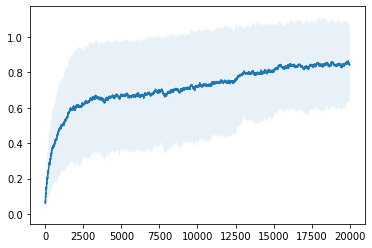

In [658]:
import matplotlib.pyplot as plt
#for l in q:
#    plt.plot(l)
means = np.array(q).mean(0)
stds = np.array(q).std(0)
plt.plot(means)
plt.fill_between(range(len(means)),means-stds,means+stds,alpha=.1)
sum([sum(a[-30:])/30 for a in q])/len(q)

0.877033333333334

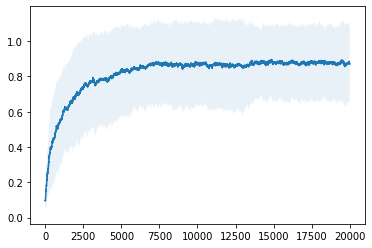

In [659]:
#for l in q1:
#    plt.plot(l)
means = np.array(q1).mean(0)
stds = np.array(q1).std(0)
plt.plot(means)
plt.fill_between(range(len(means)),means-stds,means+stds,alpha=.1)
sum([sum(a[-30:])/30 for a in q1])/len(q1)

0.9479666666666672

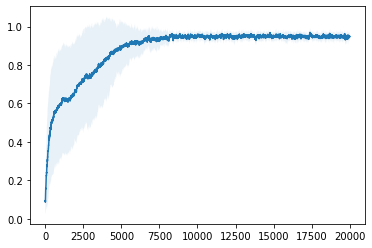

In [660]:
#for l in q2:
#    plt.plot(l)
means = np.array(q2).mean(0)
stds = np.array(q2).std(0)
plt.plot(means)
plt.fill_between(range(len(means)),means-stds,means+stds,alpha=.1)
sum([sum(a[-30:])/30 for a in q2])/len(q2)

0.8260666666666671

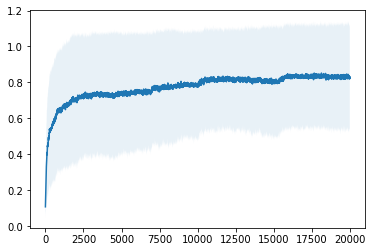

In [661]:
#for l in q3:
#    plt.plot(l)
means = np.array(q3).mean(0)
stds = np.array(q3).std(0)
plt.plot(means)
plt.fill_between(range(len(means)),means-stds,means+stds,alpha=.1)
sum([sum(a[-30:])/30 for a in q3])/len(q3)

9